# SmallNORB

In [ ]:
!pip install datasets
!pip install transformers

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision as tv
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from torchvision import transforms
from datasets import load_dataset

sns.set_theme()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
smallnorb = load_dataset("Ramos-Ramos/smallnorb")

In [5]:
class SmallNORBDataset(torch.utils.data.Dataset):
  def __init__(self, hf_dataset, subset="train", transform=None):
    self.hf_dataset = hf_dataset
    self.subset = subset
    self.transform = transform

  def __len__(self):
    return len(self.hf_dataset[self.subset])

  def __getitem__(self, idx):
    sample = self.hf_dataset[self.subset][idx]
    image = sample["image_lt"]
    label = sample["category"]

    if self.transform:
      image = self.transform(image)

    return image, label

## VGG16

In [6]:
transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=64),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

transforms_val = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

transforms_test = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

In [7]:
train_ds = SmallNORBDataset(smallnorb, "train", transform=transforms_train)
val_ds = SmallNORBDataset(smallnorb, "train", transform=transforms_val)

train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, val_size])

test_ds = SmallNORBDataset(smallnorb, "test", transform=transforms_test)

In [27]:
IN_CHANNELS = 1
N_CLASSES = 5

vgg16_model = tv.models.vgg16(weights="IMAGENET1K_V1")

In [28]:
for param in vgg16_model.parameters():
    param.requires_grad = False

In [29]:
# 1-channel inputs
vgg16_model.features[0] = nn.Conv2d(IN_CHANNELS, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))

# Add on classifier
n_inputs = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, N_CLASSES), nn.LogSoftmax(dim=1))

In [30]:
vgg16_model = vgg16_model.to(device)

In [31]:
total_params = sum(p.numel() for p in vgg16_model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in vgg16_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} trainable parameters.")

135,309,509 total parameters.
1,050,757 trainable parameters.


In [34]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

In [35]:
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(dataset=val_ds, batch_size=BATCH_SIZE)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE)

In [36]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="max", factor=0.1, patience=5, verbose=True
)

In [21]:
best_val_loss = 1e7
train_losses = list()
val_losses = list()

for epoch in range(EPOCHS):
  # Train
  vgg16_model.train()
  train_loss = 0.0
  for batch in tqdm(train_dl, desc=f"Epoch {epoch + 1}/{EPOCHS}", ncols=100):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = vgg16_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  # Validate
  vgg16_model.eval()
  val_loss = 0.0
  correct_predictions = 0
  total_predictions = 0
  with torch.no_grad():
    for batch in tqdm(val_dl, desc="Validation", ncols=100):
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = vgg16_model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()
  lr_scheduler.step(val_loss)

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(vgg16_model.state_dict(), "/content/checkpoints/vgg16-smallnorb-nopretrain.pt")

  train_losses.append(train_loss / len(train_dl))
  val_losses.append(val_loss / len(val_dl))

  accuracy = 100 * correct_predictions / total_predictions
  print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss / len(train_dl):.4f}, Validation Loss: {val_loss / len(val_dl):.4f}, Validation Accuracy: {accuracy:.2f}%")


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.64it/s]


Epoch 1/50, Train Loss: 0.7072, Validation Loss: 0.3490, Validation Accuracy: 87.10%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.62it/s]


Epoch 2/50, Train Loss: 0.3775, Validation Loss: 0.2627, Validation Accuracy: 90.08%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.51it/s]


Epoch 3/50, Train Loss: 0.3134, Validation Loss: 0.1952, Validation Accuracy: 93.46%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.52it/s]


Epoch 4/50, Train Loss: 0.2761, Validation Loss: 0.1705, Validation Accuracy: 93.81%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.67it/s]


Epoch 5/50, Train Loss: 0.2667, Validation Loss: 0.1744, Validation Accuracy: 93.54%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.76it/s]


Epoch 6/50, Train Loss: 0.2437, Validation Loss: 0.1669, Validation Accuracy: 93.70%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.64it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/50, Train Loss: 0.2348, Validation Loss: 0.1336, Validation Accuracy: 94.96%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.60it/s]


Epoch 8/50, Train Loss: 0.1807, Validation Loss: 0.1151, Validation Accuracy: 95.93%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.46it/s]


Epoch 9/50, Train Loss: 0.1768, Validation Loss: 0.1224, Validation Accuracy: 95.31%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.31it/s]


Epoch 10/50, Train Loss: 0.1731, Validation Loss: 0.1134, Validation Accuracy: 95.72%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.47it/s]


Epoch 11/50, Train Loss: 0.1657, Validation Loss: 0.1081, Validation Accuracy: 95.99%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.44it/s]


Epoch 12/50, Train Loss: 0.1656, Validation Loss: 0.1110, Validation Accuracy: 96.01%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.59it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/50, Train Loss: 0.1600, Validation Loss: 0.1076, Validation Accuracy: 95.97%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.58it/s]


Epoch 14/50, Train Loss: 0.1592, Validation Loss: 0.1066, Validation Accuracy: 96.42%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.57it/s]


Epoch 15/50, Train Loss: 0.1561, Validation Loss: 0.1066, Validation Accuracy: 96.17%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.32it/s]


Epoch 16/50, Train Loss: 0.1588, Validation Loss: 0.1078, Validation Accuracy: 96.42%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.57it/s]


Epoch 17/50, Train Loss: 0.1577, Validation Loss: 0.1094, Validation Accuracy: 96.09%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.32it/s]


Epoch 18/50, Train Loss: 0.1630, Validation Loss: 0.1094, Validation Accuracy: 95.93%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.35it/s]


Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
Epoch 19/50, Train Loss: 0.1628, Validation Loss: 0.0994, Validation Accuracy: 96.50%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.43it/s]


Epoch 20/50, Train Loss: 0.1648, Validation Loss: 0.1118, Validation Accuracy: 96.19%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.31it/s]


Epoch 21/50, Train Loss: 0.1606, Validation Loss: 0.0998, Validation Accuracy: 96.46%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.32it/s]


Epoch 22/50, Train Loss: 0.1580, Validation Loss: 0.1068, Validation Accuracy: 96.15%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.37it/s]


Epoch 23/50, Train Loss: 0.1579, Validation Loss: 0.1050, Validation Accuracy: 96.36%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.38it/s]


Epoch 24/50, Train Loss: 0.1527, Validation Loss: 0.1031, Validation Accuracy: 96.30%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.49it/s]


Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.
Epoch 25/50, Train Loss: 0.1529, Validation Loss: 0.1114, Validation Accuracy: 96.01%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.60it/s]


Epoch 26/50, Train Loss: 0.1597, Validation Loss: 0.1030, Validation Accuracy: 96.60%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.77it/s]


Epoch 27/50, Train Loss: 0.1566, Validation Loss: 0.1063, Validation Accuracy: 96.15%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.82it/s]


Epoch 28/50, Train Loss: 0.1536, Validation Loss: 0.1012, Validation Accuracy: 96.60%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:13<00:00,  5.72it/s]


Epoch 29/50, Train Loss: 0.1579, Validation Loss: 0.1061, Validation Accuracy: 96.26%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.65it/s]


Epoch 30/50, Train Loss: 0.1599, Validation Loss: 0.1003, Validation Accuracy: 96.48%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.45it/s]


Epoch 00031: reducing learning rate of group 0 to 1.0000e-07.
Epoch 31/50, Train Loss: 0.1555, Validation Loss: 0.1070, Validation Accuracy: 96.17%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.37it/s]


Epoch 32/50, Train Loss: 0.1555, Validation Loss: 0.0939, Validation Accuracy: 96.65%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.15it/s]


Epoch 33/50, Train Loss: 0.1563, Validation Loss: 0.1080, Validation Accuracy: 96.34%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.28it/s]


Epoch 34/50, Train Loss: 0.1599, Validation Loss: 0.1057, Validation Accuracy: 96.40%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.39it/s]


Epoch 35/50, Train Loss: 0.1571, Validation Loss: 0.1028, Validation Accuracy: 96.23%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.52it/s]


Epoch 36/50, Train Loss: 0.1599, Validation Loss: 0.1051, Validation Accuracy: 96.32%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.58it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-08.
Epoch 37/50, Train Loss: 0.1566, Validation Loss: 0.1029, Validation Accuracy: 96.34%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.66it/s]


Epoch 38/50, Train Loss: 0.1552, Validation Loss: 0.0967, Validation Accuracy: 96.56%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.75it/s]


Epoch 39/50, Train Loss: 0.1589, Validation Loss: 0.1041, Validation Accuracy: 96.19%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.60it/s]


Epoch 40/50, Train Loss: 0.1538, Validation Loss: 0.1117, Validation Accuracy: 95.82%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.44it/s]


Epoch 41/50, Train Loss: 0.1560, Validation Loss: 0.1062, Validation Accuracy: 96.23%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.47it/s]


Epoch 42/50, Train Loss: 0.1585, Validation Loss: 0.1082, Validation Accuracy: 96.07%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:12<00:00,  6.31it/s]


Epoch 43/50, Train Loss: 0.1578, Validation Loss: 0.1026, Validation Accuracy: 96.54%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.37it/s]


Epoch 44/50, Train Loss: 0.1601, Validation Loss: 0.1024, Validation Accuracy: 96.17%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.49it/s]


Epoch 45/50, Train Loss: 0.1570, Validation Loss: 0.0998, Validation Accuracy: 96.32%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.50it/s]


Epoch 46/50, Train Loss: 0.1620, Validation Loss: 0.1014, Validation Accuracy: 96.67%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.39it/s]


Epoch 47/50, Train Loss: 0.1545, Validation Loss: 0.1078, Validation Accuracy: 96.07%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.53it/s]


Epoch 48/50, Train Loss: 0.1578, Validation Loss: 0.1051, Validation Accuracy: 96.15%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.53it/s]


Epoch 49/50, Train Loss: 0.1567, Validation Loss: 0.1047, Validation Accuracy: 96.32%


Validation: 100%|███████████████████████████████████████████████████| 76/76 [00:11<00:00,  6.87it/s]

Epoch 50/50, Train Loss: 0.1597, Validation Loss: 0.1084, Validation Accuracy: 96.28%


Text(0.5, 1.0, 'VGG16 Training on SmallNORB')

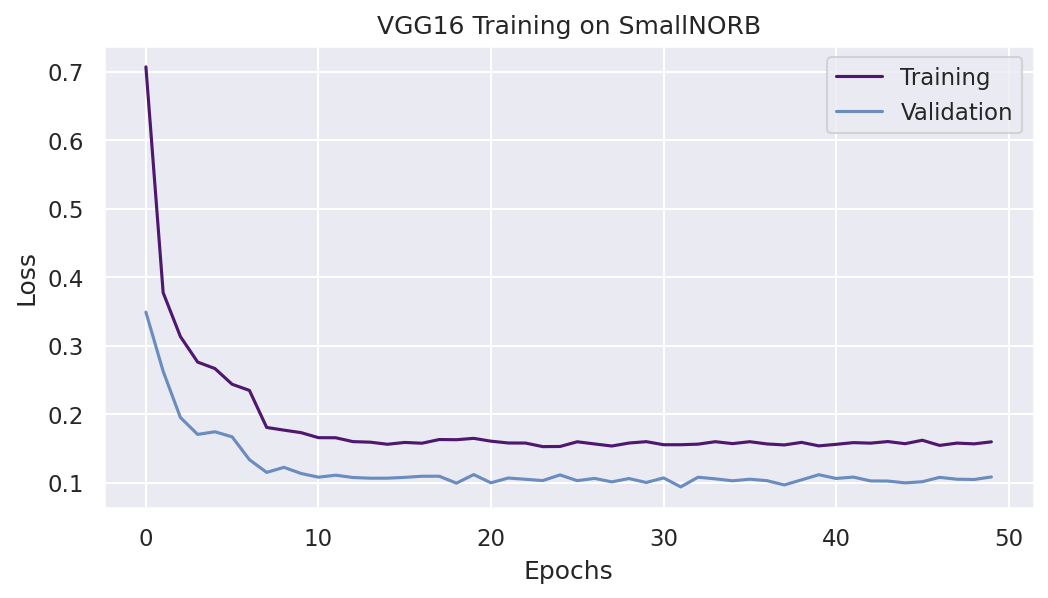

In [22]:
# Plot training results
plt.figure(figsize=(8,4), dpi=150)
plt.plot(train_losses, color=(78 / 255, 24 / 255, 111 / 255), label="Training")
plt.plot(val_losses, color=(107 / 255, 140 / 255, 191 / 255), label="Validation")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VGG16 Training on SmallNORB")

In [23]:
# Predict on Test set
vgg16_model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in tqdm(test_dl, desc="Testing", ncols=100):
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = vgg16_model(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_predictions += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

print(f"\nTest set accuracy = {(100 * correct_predictions / total_predictions):.4f}%")

Testing: 100%|████████████████████████████████████████████████████| 380/380 [02:25<00:00,  2.60it/s]


Test set accuracy = 68.3457%
